# Slow feature analysis

### Background

Slow feature analysis (SFA) is a optimization that extracts the slowest-moving features of the signal
![missing image, need to be connected to internet](http://scholarpedia.org/w/images/thumb/c/c5/SlowFeatureAnalysis-SlownessPrinciple.jpeg/400px-SlowFeatureAnalysis-SlownessPrinciple.jpeg "")


![missing image of steps of SFA](http://scholarpedia.org/w/images/thumb/d/df/SlowFeatureAnalysis-Algorithm.png/800px-SlowFeatureAnalysis-Algorithm.png "")

## Sine wave example

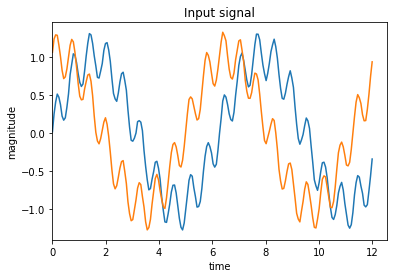

In [16]:
import numpy as np
import matplotlib.pyplot as plt
start = 0
end = 12
nsamples = 200
x = np.linspace(start,end, nsamples)

signal = np.sin(x)+0.3*np.sin(10*x)+0.05*np.random.random(x.shape)
#signal_shifted = np.sin(x-5)+0.3*np.sin(10*(x-5))+0.05*np.random.random(x.shape)

#scale to have mean 0 var 1, just for comparison purposes
rescaled_signal = (signal - np.mean(signal, 0)) / np.std(signal, 0)

plt.plot(x,signal)
#plt.plot(x,signal_shifted)
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("Input signal")
plt.xlim([0,4*np.pi])
plt.show()

In [18]:
import mdp
'''
@param signal_list n x m array with n points in time that are m dimensional
'''
lookback = 2
def flow(signal_list):
    #put into format where columns are variables and rows are observations
    ndims = signal_list[0].shape[1]
    flows = []
    for i in range(ndims):
        flow = (mdp.nodes.EtaComputerNode() +
            mdp.nodes.TimeFramesNode(lookback) +
            mdp.nodes.PolynomialExpansionNode(3) +
            mdp.nodes.SFANode(output_dim=2, include_last_sample=True) +
            mdp.nodes.EtaComputerNode() )
        
        for signal in signal_list:
            signal_to_train_on = signal[:,i]
            flow.train(signal_to_train_on.reshape(-1,1))
        flows.append(flow)
    return flows

def apply_flows(flows, signal):
    outputs = []
    for i in range(len(flows)):
        flow = flows[i]
        output = flow(signal[:,i].reshape(-1,1))
        outputs.append(output)
    return np.hstack(outputs)


(0, 12.566370614359172)

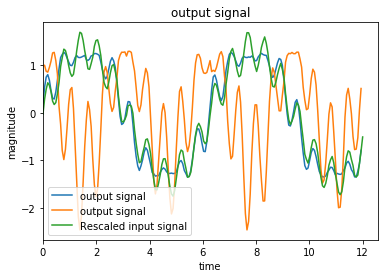

In [19]:
flows = flow([signal.reshape((len(signal), 1)), signal_shifted.reshape((len(signal), 1))])
encoded = apply_flows(flows, signal.reshape(-1,1))

plt.plot(x[:-lookback+1],encoded, label = "output signal")
plt.plot(x, rescaled_signal, label="Rescaled input signal")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("output signal")
plt.legend()
plt.xlim([0,4*np.pi])

covariance between the output signal and the rescaled input signal
eta is a measure of the slowness. The lower the value the higher the slowness

In [17]:
print("Covariance", mdp.utils.cov2(rescaled_signal[:-lookback+1], encoded))
print(flows[0])
print("eta input", flows[0][0].get_eta(t=len(signal)))

print("eta output", flows[0][-1].get_eta(t=len(signal)-lookback))

Covariance [[ 0.95500536 -0.01542252]]
[EtaComputerNode, TimeFramesNode, PolynomialExpansionNode, SFANode, EtaComputerNode]
eta input [5.68348222]
eta output [1.85766299 4.47897389]


In [ ]:
from scipy.signal import butter, lfilter, freqz
order = 2
fs = nsamples/(end-start)
cutoff = 0.4

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
y = butter_lowpass_filter(data=signal, cutoff=cutoff, fs=fs, order=order)
plt.plot(y)

# Neural net autoencoder